## This notebook compiles object-location scoring output from behavior_coding.py. 
*Data standard assumptions:*
* video name in *_ol_scoring.csv matches vidname in metadata csv. 
* *_ol_scoring.csv contains headers 'file','frame','action'


In [1]:
%reload_ext autoreload
%autoreload 2

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import sys
from logging import raiseExceptions

sys.path.append('C:/Users/schafferlab/github/SNLab_ephys/behavior/')
sys.path.append('C:/Users/schafferlab/Documents/ripple_heterogeneity/ripple_heterogeneity/utils/')
from ripple_heterogeneity.utils import  functions
import process_behavior_coding as bc

### Set paths

In [3]:
data_dir = 'Y:/laura_berkowitz/app_ps1_ephys/data'
meta_path = 'Y:/laura_berkowitz/app_ps1_ephys/behavior/object_location/object_location_metadata.csv'
save_path = 'Y:/laura_berkowitz/app_ps1_ephys/behavior/object_location/'

### Import meta data and compile object-location coding into dataframe

In [7]:
# load metadata
metadata = pd.read_csv(meta_path)
metadata.describe()

# load compiled data
df = bc.load_data(data_dir)
df.dropna(inplace=True) # drop rows with NaN
df.reset_index(drop = True,inplace=True) # reset index

# check if starts always follow stops 
check_index = bc.check_start_stop(df)
if len(check_index) > 0:
    raiseException('Stop and check data for errors')

# reorganize dataframe 
df_visit = bc.reorganize_df(df)


### Add metadata to compiled df and save

In [8]:
# add metadata to dataframe
df_visit = bc.add_metadata(df_visit, metadata)

# create column for for visit time in seconds
df_visit= bc.frames_to_seconds(df_visit, fs = 60)

# add default indicators 
df1 = bc.add_indicators(df_visit)

In [9]:
df1.keys()

Index(['file', 'start', 'stop', 'object', 'basepath', 'basename', 'subid',
       'genotype', 'age', 'session_date', 'dob', 'vidname', 'exposure',
       'condition', 'treatment', 'objects', 'paradigm', 'moved_object',
       'trial_start_1', 'trial_stop_1', 'trial_start_2', 'trial_stop_2',
       'trial_start_3', 'trial_stop_3', 'object_exploration_time',
       'first_5min', 'first_3min', 'whole_session', 'all_baseline_3min_test',
       'all_baseline_5min_test', 'trial_n', 'in_trial'],
      dtype='object')

### Compute discrimination ratio for trials, and first 3 and 5 minutes of 20min test trial

In [13]:

df_processed = bc.compute_explore_time(df1,epoch_name = 'whole_session')


day06_OLbase_hpc04
day06_OLtest_hpc04
hpc04_Base_day09-02212022113925-0000_h264
hpc04_test_day09-02212022140222-0000_h264
hpc04_OLbase_day12-02252022141631-0000_h264
hpc04_OLtest_day12-02252022172652-0000_h264
hpc04_OLbase_day15-03012022123120-0000_h264
hpc04_OLtest_day15-03012022152140-0000_h264
hpc05_OLbase_day10-03162022121030-0000
hpc05_OLtest_day10-03162022153237-0000
hpc05_OLbase_day14-03202022123016-0000_h264
hpc05_OLtest_day14-03202022155949-0000_h264
hpc05_OLbase_day17-03242022122559-0000_h264
hpc05_OLtest_day17-03242022151150-0000_h264
hpc05_OLbase_day20-03282022132022-0000_h264
hpc05_OLtest_day20-03282022161138-0000_h264
hpc06_OLbase_day14-03202022131854-0000_h264
hpc06_OLtest_day14-03202022164244-0000_h264
hpc06_OLbase_day17-03242022110709-0000_h264
hpc06_OLtest_day17-03242022142548-0000_h264
hpc06_BaseOL_day23-04012022134609-0000_h264
hpc06_TestOL_day23-04012022164229-0000_h264
hpc06_OLbase_day27-04052022132251-0000_h264
hpc06_OLtest_day27-04052022162011-0000_h264
hpc07_OL

### Add combination of factors that may be helpful for plotting

In [14]:
df_processed['subid_treatment_paradigm'] = df_processed['subid'] + '_' + df_processed['treatment'] + '_' + df_processed['paradigm']
df_processed['treatment_paradigm'] = df_processed['treatment'] + '_' + df_processed['paradigm']

df_processed['constant'] = 1
df_processed.keys()
df_processed.genotype.unique()

array(['C57bl6j', 'APPPS1'], dtype=object)

### Data cleaning 

In [16]:
# drop rows with NaN
print(df_processed.shape)
df_processed.dropna(inplace=True)
print(df_processed.shape)

# drop baseline sessions without a test 
for basepath in df_processed.basepath.unique():
    if np.sum(df_processed.basepath == basepath) == 1:
        print("dropped due to only one video: " + basepath)
        df_processed = df_processed[df_processed.basepath != basepath]

print(df_processed.shape)

# check if baseline exploration was greater than 5 seconds 
df_processed["explore_inclusion"] = True
for basename in df_processed.basename.unique():
    idx = (df_processed.basename == basename) & (df_processed.condition == "baseline")

    if df_processed.total_explore[idx].values[0] < 5:
        df_processed.loc[df_processed.basename == basename,'explore_inclusion'] = False

# check of baseline DR is within +/- .20
df_processed["DR_inclusion"] = True
for basename in df_processed.basename.unique():
    idx = (df_processed.basename == basename) & (df_processed.condition == "baseline")

    if (df_processed.DR[idx].values[0] < -0.20) | (df_processed.DR[idx].values[0] > 0.20):
        df_processed.loc[df_processed.basename == basename,'DR_inclusion'] = False

df_met = df_processed[(df_processed.explore_inclusion == True) & (df_processed.DR_inclusion == True)]

(62, 22)
(62, 22)
(62, 22)


### Plot Discrimination ratio

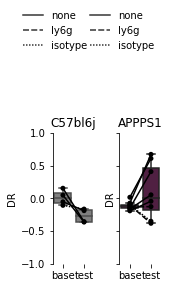

In [38]:
import seaborn as sns

group_colors = {"C57bl6j": "gray", "APPPS1": "#581845"}
sns.set_palette(sns.color_palette(group_colors.values()))

fig, ax = plt.subplots(1,2,
    figsize=functions.set_size("thesis", fraction=.33, subplots=(2, 1)), edgecolor=None,sharey=True
)
fig.subplots_adjust(wspace=0.6)
ax = ax.ravel()
group = df_processed.genotype.unique()
for i , g in enumerate(group): 
    sns.boxplot(
        y="DR",
        x="condition",
        data=df_met[df_met.genotype == g],
        color = group_colors[g],
        showfliers=False,
        ax=ax[i],
    )
    sns.stripplot(
        y="DR",
        x="condition",
        data=df_met[df_met.genotype == g],
        color="k",
        jitter=False,
        size=5,
        ax=ax[i],
    )
    sns.lineplot(
        y="DR",
        x="condition",
        data=df_met[df_met.genotype == g],
        units="basename",
        estimator=None,
        color="k",
        legend=True,
        style="treatment",
        style_order=["none", "ly6g","isotype"],
        ax=ax[i],
        zorder = 1000,
    )
    sns.despine(bottom=True)
    
    ax[i].set_title(g)
    ax[i].set_xticklabels(['base','test'])
    ax[i].set_xlabel('')

    ax[i].legend(bbox_to_anchor=(1.05, 2), loc=1,frameon=False)


ax[0].set_ylim(-1,1)

plt.savefig(save_path + "DR_boxplot.pdf", 
            dpi=300, bbox_inches='tight')


In [18]:
df_met.basename[df_met["genotype"] == 'C57bl6j']

20    hpc06_day23_220401_102719
21    hpc06_day23_220401_102719
24    hpc07_day10_220503_082347
25    hpc07_day10_220503_082347
26    hpc07_day25_220524_093304
27    hpc07_day25_220524_093304
35    hpc07_day50_220712_094047
36    hpc07_day50_220712_094047
Name: basename, dtype: object

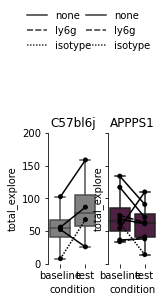

In [40]:
import seaborn as sns

group_colors = {"C57bl6j": "gray", "APPPS1": "#581845"}
sns.set_palette(sns.color_palette(group_colors.values()))

fig, ax = plt.subplots(1,2,
    figsize=functions.set_size("thesis", fraction=.33, subplots=(2, 1)), edgecolor=None,sharey=True
)
ax = ax.ravel()
group = df_processed.genotype.unique()
for i , g in enumerate(group): 
    sns.boxplot(
        y="total_explore",
        x="condition",
        data=df_met[df_met.genotype == g],
        color = group_colors[g],
        showfliers=False,
        ax=ax[i],
    )
    sns.stripplot(
        y="total_explore",
        x="condition",
        data=df_met[df_met.genotype == g],
        color="k",
        jitter=False,
        size=5,
        ax=ax[i],
    )
    sns.lineplot(
        y="total_explore",
        x="condition",
        data=df_met[df_met.genotype == g],
        units="basename",
        estimator=None,
        color="k",
        legend=True,
        style="treatment",
        style_order=["none", "ly6g","isotype"],
        ax=ax[i],
        zorder = 1000,
    )
    sns.despine(bottom=True)
    
    ax[i].set_title(g)
    ax[i].legend(bbox_to_anchor=(1.05, 2), loc=1,frameon=False)

ax[0].set_ylim(0,200)

plt.savefig(save_path + "Explore_boxplot.pdf", 
            dpi=300, bbox_inches='tight')



### Examine object exploration across groups and conditions

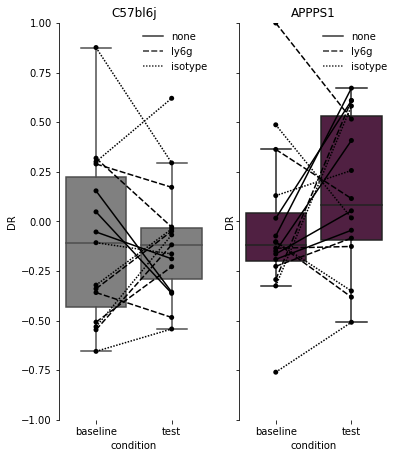

In [20]:
import seaborn as sns

group_colors = {"C57bl6j": "gray", "APPPS1": "#581845","excluded": "red"}
df_processed["met"] = df_processed.genotype
df_processed.loc[(df_processed.explore_inclusion != True) & (df_processed.DR_inclusion != True), "met"] = "excluded"
    
sns.set_palette(sns.color_palette(group_colors.values()))

fig, ax = plt.subplots(1,2,
    figsize=functions.set_size("thesis", fraction=1, subplots=(2, 1)), edgecolor=None,sharey=True
)
ax = ax.ravel()
group = df_processed.genotype.unique()
for i , g in enumerate(group): 
    sns.boxplot(
        y="DR",
        x="condition",
        data=df_processed[df_processed.genotype == g],
        color = group_colors[g],
        showfliers=False,
        ax=ax[i],
    )
    sns.stripplot(
        y="DR",
        x="condition",
        data=df_processed[df_processed.genotype == g],
        color="k",
        jitter=False,
        size=5,
        ax=ax[i],
    )
    sns.lineplot(
        y="DR",
        x="condition",
        data=df_processed[df_processed.genotype == g],
        units="basename",
        estimator=None,
        color="k",
        legend=True,
        style="treatment",
        style_order=["none", "ly6g","isotype"],
        ax=ax[i],
        zorder = 1000,
    )
    sns.despine(bottom=True)
    
    ax[i].set_title(g)
    ax[i].legend(bbox_to_anchor=(1.05, 1), loc=1,frameon=False)
ax[0].set_ylim(-1,1)

plt.savefig(save_path + "DR_all_boxplot.pdf", 
            dpi=300, bbox_inches='tight')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(-1.0, 1.0)

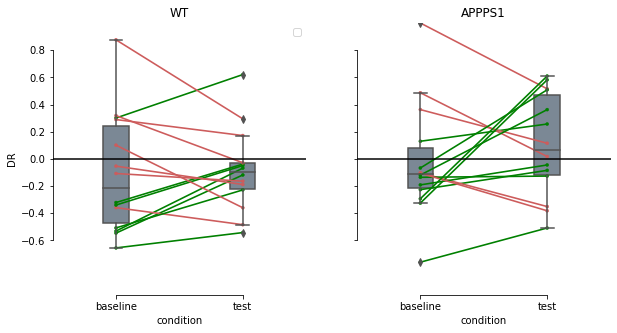

In [21]:
import pingouin as pg
fig,ax = plt.subplots(1,2,figsize=(10,5),sharey=True)
ax = ax.ravel()
plt.subplots_adjust(wspace=0.2)
idx = (df_processed['genotype'] == 'APPPS1')
pg.plot_paired(data=df_processed[~idx], dv='DR', within='condition',
                    subject='subid_treatment_paradigm', dpi=150,ax=ax[0])
pg.plot_paired(data=df_processed[idx], dv='DR', within='condition',
                    subject='subid_treatment_paradigm', dpi=150,ax=ax[1])
ax[0].axhline(0,color='black')
ax[1].axhline(0,color='black')
ax[0].set_title('WT')
ax[1].set_title('APPPS1')
ax[0].legend()
ax[0].set_ylim([-1,1])




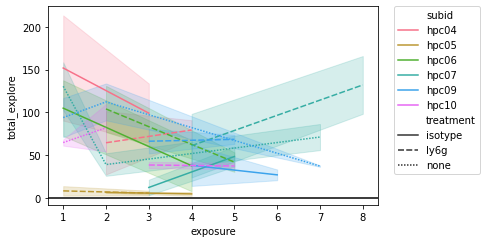

In [22]:
fig = plt.figure(figsize=functions.set_size("thesis", fraction=1, subplots=(1, 1)))

sns.lineplot(
    x="exposure",
    y="total_explore",
    color="k",
    data=df_processed,
    hue="subid",
    style="treatment",
)


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.axhline(0, color="black")


Text(0.5, 1.0, 'Explore time across exposure')

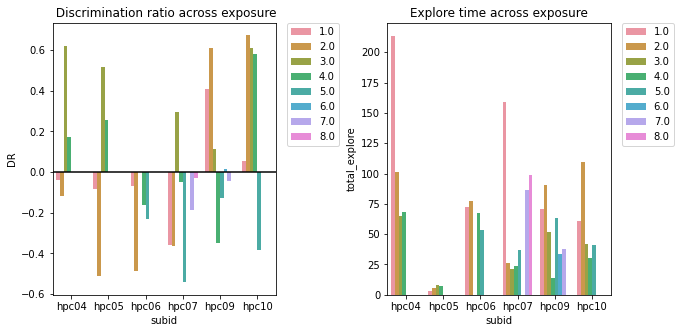

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = ax.ravel()
plt.subplots_adjust(wspace=0.5)

sns.barplot(
    x="subid",
    y="DR",
    hue="exposure",
    data=df_processed[df_processed["condition"] == "test"],
    ax=ax[0],
)
sns.barplot(
    x="subid",
    y="total_explore",
    hue="exposure",
    data=df_processed[df_processed["condition"] == "test"],
    ax=ax[1],
)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
ax[0].axhline(0, color="black")
ax[0].set_title(" Discrimination ratio across exposure")
ax[1].set_title("Explore time across exposure")
